# Augmented Reality with Python 3 and OpenCV 4.2

In this repository, I want to present a basic code of an **Augmented Reality** system, step by step, with some basic definitions, to add a 3D model aligned (orientation and translation) to a predefined flat surface.


The basic structure will be:

1. **Prepare data**
2. **Read data**
3. **Recognize data**
4. **Homography**
5. **Pose Estimation**
5. **Display**

![basic structure augmented reality](https://raw.githubusercontent.com/mafda/augmented_reality_101/master/img/basicAR_101.jpg?token=AB2XN4CZXIQLALKDMSPENAK6326V6)

## 1. Prepare data

Include libraries in Python, such as OpenCV, Numpy, and Matplotlib.

In [1]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

## 2. Read data

We need two types of data:

* Reference image: The image which doesn’t change and is used as the basis.
* Source image: The image which is geometrically aligned with the reference image.

### Read reference image

Load the reference image and convert to gray scale.

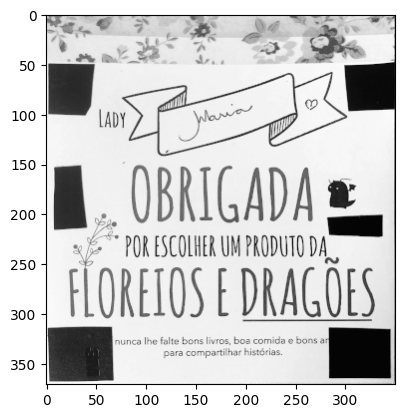

In [2]:
# Load reference image and convert it to gray scale
referenceImage = cv2.imread('../img/referenceImage.jpg', 0)

# Show image
plt.imshow(referenceImage, cmap='gray')
plt.show()

### Read source image

Load the source image and convert to gray scale.

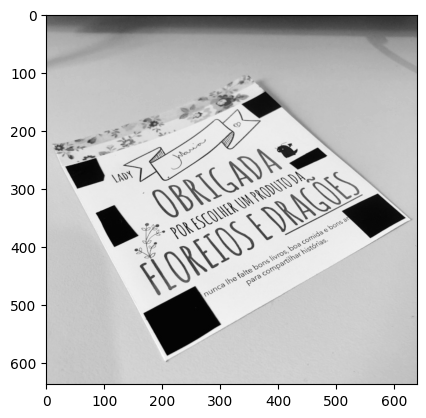

In [3]:
# Load the source image and convert it to gray scale
sourceImage = cv2.imread('../img/sourceImage_04.jpg', 0) 

# Show image
plt.imshow(sourceImage, cmap='gray')
plt.show()

## 3. Recognize

We need to recognize the reference image. [Recognition](https://en.wikipedia.org/wiki/Computer_vision#Recognition) is a computer vision technique for identifying objects, feature, or activity in images or videos.

For this project, we are going to use feature-based recognition methods. This kind of methods, consist in three main steps: 
* **3.1 Feature detection,** 
* **3.2 Feature description** and 
* **3.3 Feature matching**.

### 3.1 Feature detection

[Feature detection](https://en.wikipedia.org/wiki/Feature_detection_(computer_vision)) is a low-level image processing operation, and it is usually performed as the first operation on an image (reference imagem), and examines every pixel to see if there is a feature present at that pixel. This features is later used to find the reference imagem in the source image.

Several techniques for feature detection as edges, corners, blobs, and affine invariant (invariant against scale, rotation or brightness changes). 

After detecting the features, local image patch around the feature is extracted. The result is known as a feature descriptor or feature vector.

### 3.2 Feature description

Once we have the features and its [description](https://docs.opencv.org/3.4/df/d54/tutorial_py_features_meaning.html), you can find same features in all images and align them, stitch them together or do whatever you want.

There are many algorithms that extract image features and compute its descriptors such as [SIFT](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html), [SURF](https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html), [BRIEF](https://docs.opencv.org/3.4/dc/d7d/tutorial_py_brief.html), [FAST](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html).

We will use [ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html) for feature detection and description: *ORB is basically a fusion of FAST keypoint detector and BRIEF descriptor with many modifications to enhance the performance*.

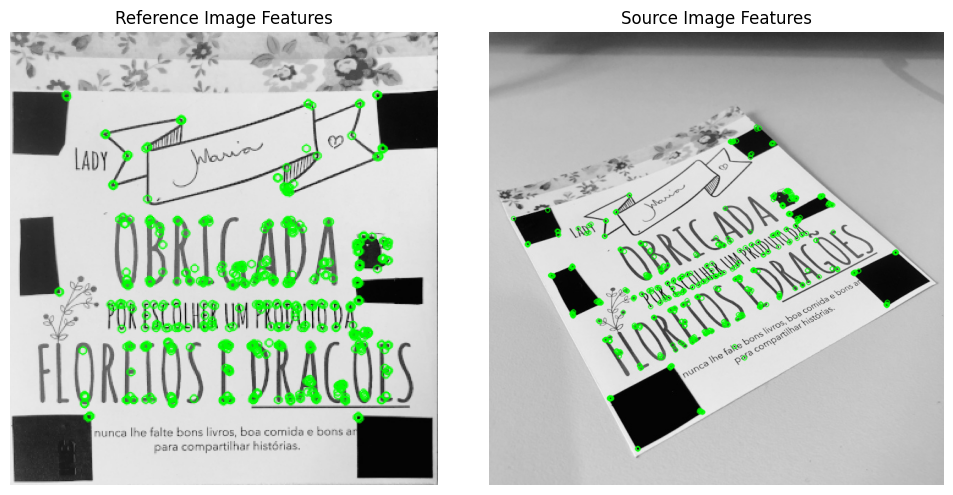

In [4]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
referenceImagePts = orb.detect(referenceImage, None)
sourceImagePts = orb.detect(sourceImage, None)

# compute the descriptors with ORB
referenceImagePts, referenceImageDsc = orb.compute(referenceImage, referenceImagePts)
sourceImagePts, sourceImageDsc = orb.compute(sourceImage, sourceImagePts)

#  Paint the key points over the original image
referenceImageFeatures = cv2.drawKeypoints(referenceImage, referenceImagePts,
                                           referenceImage, color=(0,255,0), flags=0)
sourceImageFeatures = cv2.drawKeypoints(sourceImage, sourceImagePts,
                                           sourceImage, color=(0,255,0), flags=0)


# Show image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(referenceImageFeatures, cmap='gray')
plt.title('Reference Image Features')
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(sourceImageFeatures, cmap='gray')
plt.title('Source Image Features')
plt.tight_layout()
plt.show()

### 3.3 Feature matching

At this point, we already have the features of the reference image and the source image, as well as their descriptors. With these data we can search for matches between them.

One method of matching a feature in the reference image to a feature in the source image is to use the ratio of the distance between the features and return the closest as the best match.

After finding the matches between both images, we need to decide if the reference image was found in the source image or not. For this, a minimum number of matches to be found in the image is defined. If in the source image, the number of matches is greater than the defined number, we can consider that the reference image was found in the source image.

We will use [Brute-Force Matcher ](https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html) for feature matching.

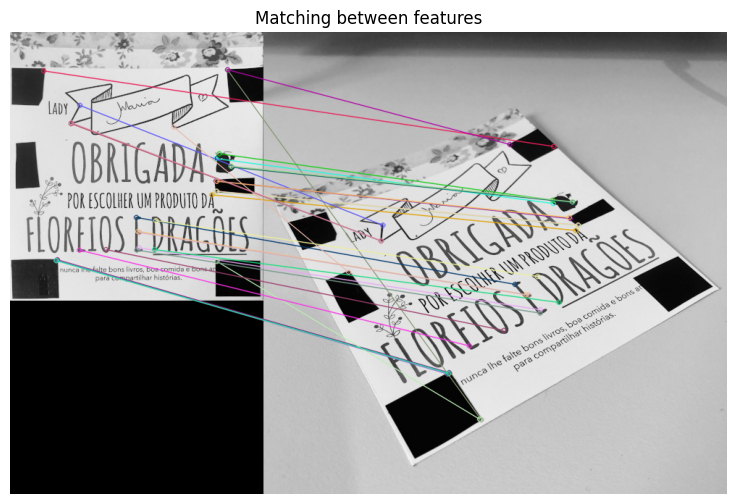

In [5]:
MIN_MATCHES = 30
            
# create brute force  matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Compute model keypoints and its descriptors
referenceImagePts, referenceImageDsc = orb.detectAndCompute(referenceImage, None)

# Compute scene keypoints and its descriptors
sourceImagePts, sourceImageDsc = orb.detectAndCompute(sourceImage, None)

# Match frame descriptors with model descriptors
matches = bf.match(referenceImageDsc, sourceImageDsc)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # draw first 15 matches.
    idxPairs = cv2.drawMatches(referenceImage, referenceImagePts, sourceImage, sourceImagePts,
                          matches[:MIN_MATCHES], 0, flags=2)
    # show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(idxPairs, cmap='gray')
    plt.title('Matching between features')
    plt.show()
    
else:
    print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

## 4. Homography

After considering that the reference image was found in the source image, the next step is to find a way to map the points of the plane of the surface of the reference image to the plane of the source image. This transformation is known as Homography. A homography is a 2D projective transformation that maps points in one plane (in homogeneous coordinates) to another, and it is defined by the following equation:

$ \begin{bmatrix} x' \\  y' \\  z' \end{bmatrix} =  \begin{bmatrix} h_1 & h_2 & h_3 \\  h_4 & h_5 & h_6 \\ 
h_7 & h_8 & h_9 \end{bmatrix}  \begin{bmatrix} x \\  y \\  z \end{bmatrix} $

We can use a function **cv2.findHomography()**. If we pass the set of points from both the images, it will find the perpective transformation of that object. Then we can use **cv2.perspectiveTransform()** to find the object. It needs at least four correct points to find the transformation.

The homography between the two images contains inliers, which are the data points that the model can describe and outliers, which are those that do not fit the model. This information may cause possible errors while matching which may affect the result. To solve this problem, algorithm uses **RANSAC** (RANdom SAmple Consensus) or LEAST_MEDIAN. So good matches which provide correct estimation are called inliers and remaining are called outliers. 

We use **cv2.RANSAC**, an iterative method to fit models to data that can contain outliers.

Finally, once the homography is estimated, we project the four corners of the reference image on the source image and connect them with a line. We use **cv2.polylines** for draw a polygon.

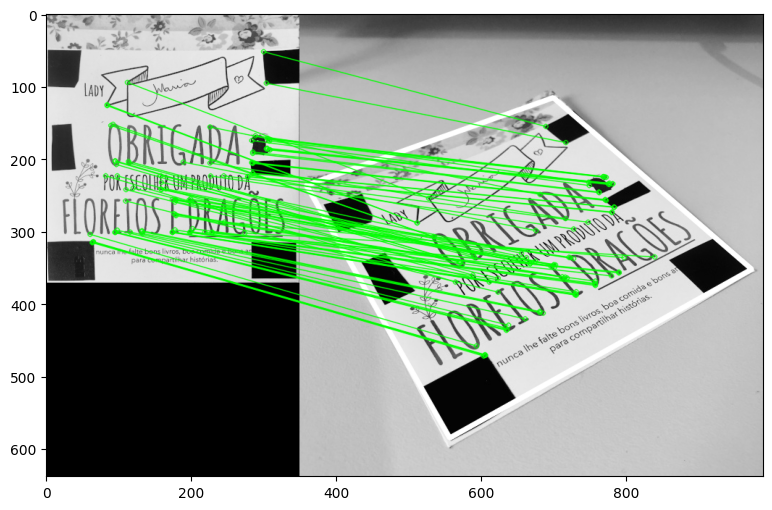

In [6]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, mask = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    sourceImageMarker = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True,
                                      255, 5, cv2.LINE_AA)
    
else:
    print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                      matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(referenceImage, referenceImagePts, sourceImageMarker,
                         sourceImagePts, matches, None, **drawParameters)

# Show image
plt.figure(figsize=(12, 6))
plt.imshow(result, cmap='gray')
plt.show()

## 5. Pose Estimation

To calculate the camera’s pose (rotation and translation), we combine the estimated homography with the parameters of a calibrated camera.

### Camera parameters

[Pinhole](https://en.wikipedia.org/wiki/Pinhole_camera_model) camera model is a widely used camera model that describes the mathematical relationship between the coordinates of a 3D point and its projection onto the image plane (both expressed in homogeneous coordinates) as $\lambda x = PX$, where $P$ is called the camera matrix (or projection matrix), the 3D point $X$ has four elements in homogeneous coordinates, $X=[X, Y, Z, W]$, and the scalar $\lambda$ is the inverse depth of the 3D point.

The camera matrix can be decomposed as $P=K[R|t]$, where $R$ is a rotation matrix describing the orientation of the camera, $t$ a 3D translation vector describing the position of the camera center, and the intrinsic calibration matrix $K$ describing the projection properties of the camera.

The calibration matrix or intrinsic parameters matrix is written as:

$ K =  \begin{bmatrix} f & 0 & c_x \\  0 & f & c_y \\ 0 & 0 & 1 \end{bmatrix} $

Now with the homography and a camera calibration matrix, we can now determine the relative transformation between the two views or projection matrix.

So, we combined feature matching with homographies and camera calibration to produce a simple example of placing a 3D object in a planar image. With camera pose estimation, we now have to build a 3D object in the reference image, for creating simple augmented reality application.


### 3D Object

We are using simple models in format [Wavefront .obj](https://en.wikipedia.org/wiki/Wavefront_.obj_file) from [claro.io](https://clara.io), and [OBJFileLoader](https://github.com/yarolig/OBJFileLoader) loads the 3D models provided by [Pygame](https://www.pygame.org/wiki/OBJFileLoader). 

After loading the 3D model, a function is implemented to read the data and project it to the top of the video frame with the projection matrix that was obtained. To do this, we take all the points used to define the model and multiply it by the projection matrix.

In [7]:
from objloader_simple import *

# Camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Load 3D model from OBJ file
obj = OBJ('../models/chair.obj', swapyz=True)

In [8]:
def projection_matrix(camera_parameters, homography):
    
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    
    return np.dot(camera_parameters, projection)

In [9]:
# project cube or model
def render(img, obj, projection, model, color=False):

    vertices = obj.vertices
    scale_matrix = np.eye(3) * 6
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)

        cv2.fillConvexPoly(img, imgpts, (80, 27, 211))
    return img

In [10]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, _ = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    frame = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)
    
    # obtain 3D projection matrix from homography matrix and camera parameters
    projection = projection_matrix(camera_parameters, homography)  
    
    # project cube or model
    frame = render(frame, obj, projection, referenceImage, False)

## 6. Display

Finally, we fill the faces of the model with color.

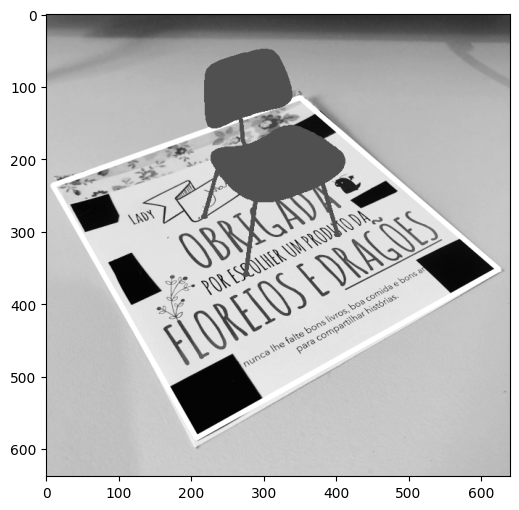

In [11]:
# Show image
plt.figure(figsize=(12, 6))
plt.imshow(frame, cmap='gray')
plt.show()

> For more details read this complete [post](https://bitesofcode.wordpress.com/2017/09/12/augmented-reality-with-python-and-opencv-part-1/), or this [book](http://programmingcomputervision.com/downloads/ProgrammingComputerVision_CCdraft.pdf).

## References

* JE Solem, *Programming Computer Vision with Python: Tools and algorithms for analyzing images*. O'Reilly Media, Inc.
* [Programming Computer Vision with Python](http://programmingcomputervision.com/)
* [Open source Python module for computer vision ](https://github.com/jesolem/PCV)
* [Augmented reality with Python and OpenCV](https://bitesofcode.wordpress.com/2017/09/12/augmented-reality-with-python-and-opencv-part-1/)
* [augmented-reality](https://github.com/juangallostra/augmented-reality)
* [OBJFileLoader](https://github.com/yarolig/OBJFileLoader)
